In [1]:
import numpy as np
import scipy.stats as ss
import time

#Black and Scholes
def d1(S0, K, r, sigma, T):
    return (np.log(S0/K) + (r + sigma**2 / 2) * T)/(sigma * np.sqrt(T))
 
def d2(S0, K, r, sigma, T):
    return (np.log(S0 / K) + (r - sigma**2 / 2) * T) / (sigma * np.sqrt(T))
 
def BlackScholes(type,S0, K, r, sigma, T):
    if type=="C":
        return S0 * ss.norm.cdf(d1(S0, K, r, sigma, T)) - \
                K * np.exp(-r * T) * ss.norm.cdf(d2(S0, K, r, sigma, T))
    else:
       return K * np.exp(-r * T) * ss.norm.cdf(-d2(S0, K, r, sigma, T)) - \
                S0 * ss.norm.cdf(-d1(S0, K, r, sigma, T))

In [2]:
start=time.time()
c_BS = BlackScholes('C', 29.0, 32.0, 0.03, 0.25, 1.0)
p_BS = BlackScholes('P', 29.0, 32.0, 0.03, 0.25, 1.0)
elapsed=time.time()-start
print "call Black-Scholes price:", c_BS, p_BS, elapsed

call Black-Scholes price: 2.0704673009 4.12472437445 0.00400018692017


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import math

def FDM_Explicit(type,S0,K,r,sigma,T,n):
    dt = T/n
    dx = sigma*np.sqrt(3*dt)         #user-defined
    v = r - 0.5*(sigma**2)
    p_u = 0.5*((sigma**2*dt/dx**2)+(v*dt/dx))
    p_m = 1 - (sigma**2*dt/dx**2)
    p_d = 0.5*((sigma**2*dt/dx**2)-(v*dt/dx))
    disc = 1/(1+r*dt)

    Lattice = np.zeros((2*n+1,n+1))
    Lattice[n,0] = S0

#The diagonal elements to T_n
    for j in range(1,n+1):
        Lattice[n-j,j]=Lattice[n-(j-1),j-1]*math.exp(dx)
        Lattice[n+j,j]=Lattice[n+(j-1),j-1]*math.exp(-dx)

#The elements in between to complete the lattice
    for j in range(1,n+1):
        Lattice[j,n-j+1:n+1]=Lattice[j,n-j] #values in row j top half
        #(horizontal mirror of lower triangular)

    for j in range(n+1,2*n+1):
        Lattice[j,j-n+1:n+1]=Lattice[j,j-n] #values in row j bottom half(upper triangular)

#For option price
    Opt = np.zeros((2*n+1,n+1))
    if type=="C":
        Opt[:,n] = np.maximum(Lattice[:,n]-K,0)
    else:
        Opt[:,n] = np.maximum(-Lattice[:,n]+K,0)

#Boundary conditions
    Top =  Lattice[0,n]-Lattice[1,n]
    Bottom = Lattice[2*n,n]-Lattice[2*n-1,n]

    if type=="C":
        for j in range(n-1, -1, -1):
            Opt[0,j]=Top                       
            Opt[2*n,j] = 0
            for i in range(1,2*n-1):
                Opt[i,j]=disc*(p_u*Opt[i-1,j+1]+p_m*Opt[i,j+1]+p_d*Opt[i+1,j+1])
    else:
        for j in range(n-1, -1, -1):
            Opt[2*n,j]=Bottom                       
            Opt[0,j] = 0
            for i in range(1,2*n-1):
                Opt[i,j]=disc*(p_u*Opt[i-1,j+1]+p_m*Opt[i,j+1]+p_d*Opt[i+1,j+1])

    Price = Opt[n,0]
    return Price
#ref: http://www.goddardconsulting.ca/option-pricing-finite-diff-explicit.html

In [4]:
FDM_Explicit('C',29.0,32.0,0.03,0.25,1.0,100)

2.0717843074810292

In [5]:
FDM_Explicit('p',29.0,32.0,0.03,0.25,1.0,100)

4.1260508551191446

In [6]:
def FDM_Implicit(type,S0,K,r,sigma,T,n):
    dt = T/n
    dx = sigma*np.sqrt(3*dt)           #user-defined
    v = r - 0.5*(sigma**2)
    p_u = -0.5*((sigma**2*dt/dx**2)+(v*dt/dx))
    p_m = 1 + (sigma**2*dt/dx**2)+ r*dt
    p_d = -0.5*((sigma**2*dt/dx**2)-(v*dt/dx))
    
    # Probability Matrix
    P=np.zeros((2*n+1,2*n+1))
    for i in range(n-(n-1),n+(n-1)+1):
        P[i,i-1]=p_u
        P[i,i]=p_m
        P[i,i+1]=p_d
    P[((0,2*n),(0,2*n-1))]=1
    P[((0,2*n),(1,2*n))]=-1
    
    disc = 1/(1+r*dt)

    Lattice = np.zeros((2*n+1,n+1))
    Lattice[n,0] = S0

#The diagonal elements to T_n
    for j in range(1,n+1):
        Lattice[n-j,j]=Lattice[n-(j-1),j-1]*math.exp(dx)
        Lattice[n+j,j]=Lattice[n+(j-1),j-1]*math.exp(-dx)

#The elements in between to complete the lattice
    for j in range(1,n+1):
        Lattice[j,n-j+1:n+1]=Lattice[j,n-j] #values in row j top half
        #(horizontal mirror of lower triangular)

    for j in range(n+1,2*n+1):
        Lattice[j,j-n+1:n+1]=Lattice[j,j-n] #values in row j bottom half(upper triangular)

#For option price
    Opt = np.zeros((2*n+1,n+1))
    if type=="C":
        Opt[:,n] = np.maximum(Lattice[:,n]-K,0)
    else:
        Opt[:,n] = np.maximum(-Lattice[:,n]+K,0)

#Boundary conditions
    Top =  Lattice[0,n]-Lattice[1,n]
    Bottom = Lattice[2*n,n]-Lattice[2*n-1,n]
    
    Price=np.zeros((2*n+1,1))

#form matrix equation Probability*Price = Call or Put
    if type=="C":
        Call = np.zeros((2*n+1,1))
        Call[1:2*n,0]=Opt[1:2*n,n]
        Call[0,0]=Top
        Call[2*n,0]=0
        
        for j in range(n, -1, -1):
            Price=np.dot(np.linalg.inv(P),Call)
            Opt[:,j-1]=Price[:,0]
            Call[:,0]=Price[:,0]
        Answer=Opt[n,0]
    else:
        Put = np.zeros((2*n+1,1))
        Put[1:2*n,0]=Opt[1:2*n,n]
        Put[0,0]=0
        Put[2*n,0]=Bottom
        
        for j in range(n, -1, -1):
            Price=np.dot(np.linalg.inv(P),Put)
            Opt[:,j-1]=Price[:,0]
            Put[:,0]=Price[:,0]
        Answer=Opt[n,0]

    return Answer

#Ref: http://www.goddardconsulting.ca/option-pricing-finite-diff-implicit.html

In [7]:
FDM_Implicit('C',29.0,32.0,0.03,0.25,1.0,100)

2.0664152161555989

In [8]:
FDM_Implicit('P',29.0,32.0,0.03,0.25,1.0,100)

4.1206817247149949

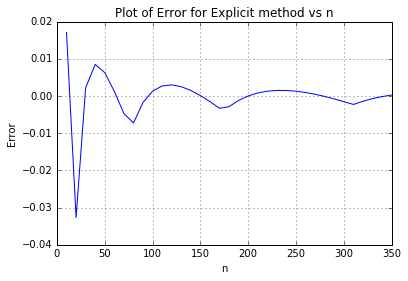

In [9]:
Analytical_Price = BlackScholes('C',29.0,32.0,0.03,0.25,1.0)
time_steps = np.arange(10, 360, 10)
Error=np.zeros(len(time_steps))
for i in time_steps:
    Error[time_steps==i]= FDM_Explicit('C',29.0,32.0,0.03,0.25,1.0,i) - Analytical_Price

plt.plot(time_steps,Error)
plt.title('Plot of Error for Explicit method vs n')
plt.xlabel('n')
plt.ylabel('Error')
plt.grid(True)
plt.show()    

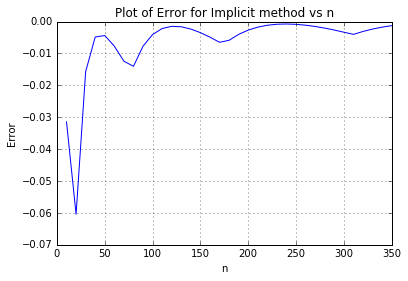

In [11]:
Error2=np.zeros(len(time_steps))
for i in time_steps:
    Error2[time_steps==i]= FDM_Implicit('C',29.0,32.0,0.03,0.25,1.0,i) - Analytical_Price

plt.plot(time_steps,Error2)
plt.title('Plot of Error for Implicit method vs n')
plt.xlabel('n')
plt.ylabel('Error')
plt.grid(True)
plt.show() 

In [12]:
Explicit_method_prices = Error + Analytical_Price
Implicit_method_prices = Error2+ Analytical_Price

#for time steps 10, 20,...350, call option prices
print Explicit_method_prices
print Implicit_method_prices

[ 2.08754271  2.03778422  2.07268691  2.0789545   2.0767545   2.07169923
  2.06573843  2.06321881  2.06874821  2.07178431  2.07317381  2.0734516
  2.07296725  2.07195556  2.07057791  2.06894729  2.06714405  2.06761652
  2.06929784  2.0704929   2.07129142  2.07176484  2.07197056  2.07195501
  2.07175608  2.07140482  2.07092688  2.0703435   2.06967242  2.06892848
  2.06819865  2.06906278  2.06976108  2.07031264  2.07073413]
[ 2.03901851  2.01004775  2.05477435  2.06563936  2.06609108  2.06276756
  2.05803153  2.0564516   2.06276388  2.06641522  2.06830067  2.06898676
  2.06884447  2.06812365  2.06699648  2.06558392  2.06397232  2.06462187
  2.06646532  2.06780519  2.06873381  2.06932476  2.06963717  2.06971893
  2.06960909  2.06933974  2.06893734  2.06842389  2.06781772  2.06713418
  2.06646087  2.06738067  2.06813104  2.06873141  2.06919872]
